<a href="https://www.kaggle.com/code/mustafaatakanyucel/karar-a-a-lar-decision-trees?scriptVersionId=259303575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🌳 Karar Ağacı Nedir?
Günlük hayatımızda sürekli karar ağaçları kullanırız. Örneğin:

"Hava yağmurlu mu? Evet → Şemsiye al, Hayır → Güneş gözlüğü al"
"Kredi puanı yüksek mi? Evet → Kredi ver, Hayır → Kredi verme"

İşte karar ağaçları da tam olarak böyle çalışır! Veriyi hiyerarşik sorular sorarak böler ve en sonunda bir karar verir.

📊 Pratik Bir Örnekle Başlayalım
İris çiçeği veri setiyle basit bir karar ağacı oluşturalım:

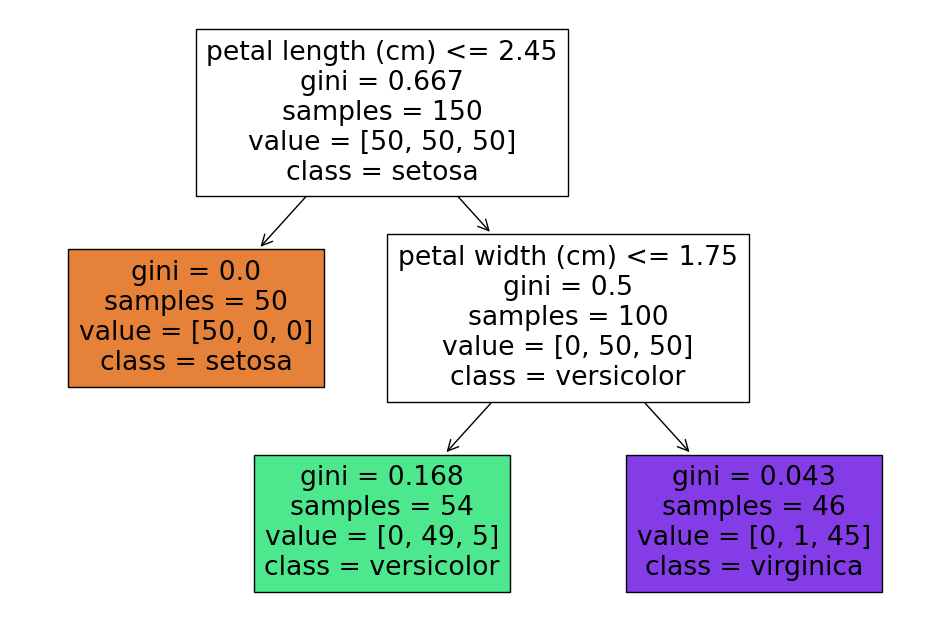

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Veri setini yükle
iris = load_iris()
X = iris.data[:, 2:]  # Sadece petal length ve width kullanıyoruz
y = iris.target

# Karar ağacını eğit
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

# Ağacı görselleştir
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=iris.feature_names[2:], 
          class_names=iris.target_names, filled=True)
plt.show()

#### Bu kod çalıştığında, ağacın her düğümünde şu bilgileri görebiliriz:

#### Karar kuralı (örn: petal length ≤ 2.45)
#### Gini impurity değeri (safsızlık ölçüsü)
#### Samples sayısı (o düğümdeki örnek sayısı)
#### Value dizisi (her sınıftan kaç örnek var)

### 🔍 Karar Ağacı Nasıl Karar Verir?
#### 1. Tahmin Süreci
#### Yeni bir örnek geldiğinde ağaç şu adımları takip eder:

In [3]:
def manual_prediction(sample):
    """Elle bir tahminin nasıl yapıldığını gösterir"""
    petal_length, petal_width = sample
    
    # Kök düğüm: petal_length <= 2.45?
    if petal_length <= 2.45:
        return "setosa"  # Sol alt ağaç
    else:
        # Sağ alt ağaç: petal_width <= 1.75?
        if petal_width <= 1.75:
            return "versicolor"
        else:
            return "virginica"

# Test edelim
test_sample = [5.1, 1.8]  # petal_length=5.1, petal_width=1.8
print(f"Manuel tahmin: {manual_prediction(test_sample)}")
print(f"Sklearn tahmini: {iris.target_names[tree_clf.predict([test_sample])[0]]}")

Manuel tahmin: virginica
Sklearn tahmini: virginica


### 2. Sınıf Olasılıkları
Karar ağaçları sadece sınıf tahmini değil, olasılık da verir:

In [4]:
# Olasılıkları hesapla
probabilities = tree_clf.predict_proba([test_sample])[0]

for i, class_name in enumerate(iris.target_names):
    print(f"{class_name}: %{probabilities[i]*100:.1f}")

setosa: %0.0
versicolor: %2.2
virginica: %97.8


## ⚙️ Algoritmanın İç Yapısı: CART
Scikit-learn, CART (Classification and Regression Trees) algoritmasını kullanır. Bu algoritma:
### 1. Özellik Seçimi
Her bölünmede en iyi özelliği şu şekilde bulur:

In [5]:
# Gini impurity hesaplama fonksiyonu
def gini_impurity(y):
    """Gini impurity değerini hesaplar"""
    m = len(y)
    if m <= 1:
        return 0
    
    # Her sınıfın oranını hesapla
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / m
    
    # Gini = 1 - Σ(p_i^2)
    return 1 - np.sum(probabilities**2)

# Örnek hesaplama
sample_labels = [0, 0, 1, 1, 1, 2]
print(f"Gini impurity: {gini_impurity(sample_labels):.3f}")

Gini impurity: 0.611


### 2. En İyi Bölünme Noktası

In [6]:
def find_best_split(X, y, feature_idx):
    """Belirli bir özellik için en iyi bölünme noktasını bulur"""
    best_threshold = None
    best_gini = float('inf')
    
    # Bu özelliğin tüm benzersiz değerlerini dene
    thresholds = np.unique(X[:, feature_idx])
    
    print(f"Özellik {feature_idx} için {len(thresholds)} farklı threshold deneniyor...")
    
    for threshold in thresholds:
        # Sol ve sağ grupları oluştur
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            continue
            
        # Ağırlıklı Gini impurity hesapla
        left_gini = gini_impurity(y[left_mask])
        right_gini = gini_impurity(y[right_mask])
        
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)
        n_total = len(y)
        
        weighted_gini = (n_left/n_total) * left_gini + (n_right/n_total) * right_gini
        
        if weighted_gini < best_gini:
            best_gini = weighted_gini
            best_threshold = threshold
            
        # Debug: İlk birkaç threshold'u yazdır
        if threshold == thresholds[0] or threshold == thresholds[-1]:
            print(f"  Threshold {threshold:.2f}: Left={n_left}, Right={n_right}, Gini={weighted_gini:.4f}")
    
    return best_threshold, best_gini

# Fonksiyonu test edelim
iris = load_iris()
X = iris.data[:, 2:]  # Petal length ve width
y = iris.target

# Her özellik için en iyi bölünme noktasını bul
for feature_idx in range(X.shape[1]):
    feature_name = iris.feature_names[2 + feature_idx]
    print(f"\n=== {feature_name} (Özellik {feature_idx}) ===")
    
    best_threshold, best_gini = find_best_split(X, y, feature_idx)
    
    print(f"En iyi threshold: {best_threshold}")
    print(f"En iyi Gini impurity: {best_gini:.4f}")
    
    # Bu bölünme ile hangi sınıflar hangi tarafa gidiyor?
    if best_threshold is not None:
        left_mask = X[:, feature_idx] <= best_threshold
        right_mask = ~left_mask
        
        print(f"Sol dalda {np.sum(left_mask)} örnek, sağ dalda {np.sum(right_mask)} örnek")
        print(f"Sol dal sınıf dağılımı: {np.bincount(y[left_mask])}")
        print(f"Sağ dal sınıf dağılımı: {np.bincount(y[right_mask])}")


=== petal length (cm) (Özellik 0) ===
Özellik 0 için 43 farklı threshold deneniyor...
  Threshold 1.00: Left=1, Right=149, Gini=0.6622
En iyi threshold: 1.9
En iyi Gini impurity: 0.3333
Sol dalda 50 örnek, sağ dalda 100 örnek
Sol dal sınıf dağılımı: [50]
Sağ dal sınıf dağılımı: [ 0 50 50]

=== petal width (cm) (Özellik 1) ===
Özellik 1 için 22 farklı threshold deneniyor...
  Threshold 0.10: Left=5, Right=145, Gini=0.6437
En iyi threshold: 0.6
En iyi Gini impurity: 0.3333
Sol dalda 50 örnek, sağ dalda 100 örnek
Sol dal sınıf dağılımı: [50]
Sağ dal sınıf dağılımı: [ 0 50 50]


## 🎯 Regresyon ile Karar Ağaçları
Karar ağaçları sadece sınıflandırma değil, regresyon için de kullanılabilir:

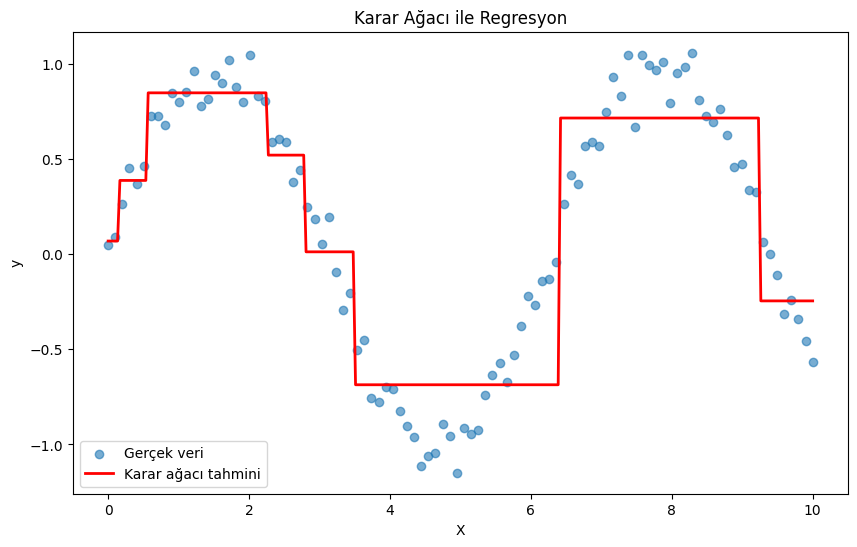

In [7]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Basit bir regresyon problemi oluşturalım
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Regresyon ağacını eğit
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X, y)

# Tahminleri görselleştir
X_test = np.linspace(0, 10, 300).reshape(-1, 1)
y_pred = tree_reg.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, label='Gerçek veri')
plt.plot(X_test, y_pred, 'r-', linewidth=2, label='Karar ağacı tahmini')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Karar Ağacı ile Regresyon')
plt.show()

### Regresyonda fark şu: Her yaprakta sınıf etiketi yerine ortalama değer bulunur.

### ✅ Avantajlar:

#### Yorumlanabilir: Kararları kolayca anlayabilirsiniz
#### Hazırlık gerektirmez: Özellik ölçeklendirme gerekmez
#### Karma veri tipleri: Sayısal ve kategorik özellikler birlikte kullanılabilir
#### Özellik seçimi: Otomatik olarak önemli özellikleri bulur
#### Eksik veri toleransı: Eksik değerlerle başa çıkabilir

### ❌ Dezavantajlar:

#### Overfitting eğilimi: Çok karmaşık ağaçlar ezberci davranır
#### Kararsızlık: Küçük veri değişiklikleri farklı ağaçlar üretebilir
#### Bias: Bazı sınıflara karşı önyargılı olabilir
#### Doğrusal ilişkilerde zayıf: Doğrusal modeller daha basit olur

## 🎛️ Hiperparametre Optimizasyonu
Karar ağaçlarında önemli hiperparametreler:

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris

iris = load_iris()
X_full = iris.data  
y_full = iris.target  

print(f"X veri tipi: {X_full.dtype}")
print(f"y veri tipi: {y_full.dtype}")
print(f"y benzersiz değerleri: {np.unique(y_full)}")
print(f"Veri boyutu: X={X_full.shape}, y={y_full.shape}")

# Farklı hiperparametrelerle deneme
params_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 50]
}

# Grid search ile en iyi parametreleri bul
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # İlerleme durumunu göster
)

# Tüm özellikleri kullanarak fit et
grid_search.fit(X_full, y_full)
print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"En iyi skor: {grid_search.best_score_:.3f}")

# Eğer sadece petal özelliklerini kullanmak istiyorsan:
print("\n=== Sadece Petal Özellikleri ile ===")
X_petal = iris.data[:, 2:]  # Sadece petal length ve width
y_clean = iris.target.astype(int)  # Kategorik olduğundan emin ol

# Basit parametrelerle deneme
simple_params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_petal = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    simple_params,
    cv=3,  # Daha az fold
    scoring='accuracy'
)

grid_search_petal.fit(X_petal, y_clean)
print(f"Petal özellikleri - En iyi parametreler: {grid_search_petal.best_params_}")
print(f"Petal özellikleri - En iyi skor: {grid_search_petal.best_score_:.3f}")

X veri tipi: float64
y veri tipi: int64
y benzersiz değerleri: [0 1 2]
Veri boyutu: X=(150, 4), y=(150,)
Fitting 5 folds for each of 180 candidates, totalling 900 fits
En iyi parametreler: {'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
En iyi skor: 0.973

=== Sadece Petal Özellikleri ile ===
Petal özellikleri - En iyi parametreler: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Petal özellikleri - En iyi skor: 0.967


### Hiperparametreler Detayı:

#### max_depth: Ağacın maksimum derinliği (overfitting kontrolü)
#### min_samples_split: Bölünme için minimum örnek sayısı
#### min_samples_leaf: Yaprakta minimum örnek sayısı
#### max_leaf_nodes: Maksimum yaprak sayısı
#### min_impurity_decrease: Bölünme için minimum safsızlık azalması

## 📈 Model Performansını Değerlendirme

Veri kontrolü - X: (150, 4), y: (150,)
Özellikler: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Sınıflar: ['setosa' 'versicolor' 'virginica']
Sınıf dağılımı: [50 50 50]

Veri bölme sonrası:
Train set: X=(120, 4), y=(120,)
Test set: X=(30, 4), y=(30,)

Hiperparametre optimizasyonu başlıyor...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
En iyi parametreler: {'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
En iyi CV skoru: 0.942

Test accuracy: 0.933


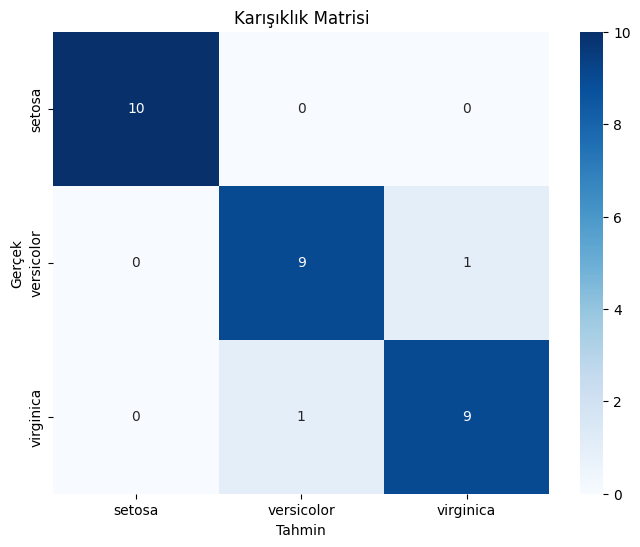

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


--- Örnek Tahminler ---
Örnek 1:
  Özellikler: [4.4 3.  1.3 0.2]
  Gerçek: setosa
  Tahmin: setosa
  Olasılıklar:
    setosa: 1.000
    versicolor: 0.000
    virginica: 0.000

Örnek 2:
  Özellikler: [6.1 3.  4.9 1.8]
  Gerçek: virginica
  Tahmin: virginica
  Olasılıklar:
    setosa: 0.000
    versicolor: 0.000
    virginica: 1.000

Örnek 3:
  Özellikler: [4.9 2.4 3.3 1. ]
  Gerçek: versicolor
  Tahmin: versicolor
  Olasılıklar:
    setosa: 0.000
    versicolor: 1.000
    virginica: 0.000

Örnek 4:
  Özellikler: [5.  2.3 3.3 1. ]
  Gerçek: versicolor
  Tahmin: versicolor
  Olasılıkla

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

iris = load_iris()
X_full = iris.data  
y_full = iris.target.astype(int) 

print(f"Veri kontrolü - X: {X_full.shape}, y: {y_full.shape}")
print(f"Özellikler: {iris.feature_names}")
print(f"Sınıflar: {iris.target_names}")
print(f"Sınıf dağılımı: {np.bincount(y_full)}")

# Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nVeri bölme sonrası:")
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

# Hiperparametre optimizasyonu
print("\nHiperparametre optimizasyonu başlıyor...")
params_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV skoru: {grid_search.best_score_:.3f}")

# En iyi modeli al
best_tree = grid_search.best_estimator_

# Test seti üzerinde tahmin yap
y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)

print(f"\nTest accuracy: {best_tree.score(X_test, y_test):.3f}")

# Karışıklık matrisi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Karışıklık Matrisi')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# Detaylı rapor
print("--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Örnek tahminler
print("\n--- Örnek Tahminler ---")
for i in range(min(5, len(X_test))):
    actual = iris.target_names[y_test[i]]
    predicted = iris.target_names[y_pred[i]]
    probabilities = y_pred_proba[i]
    
    print(f"Örnek {i+1}:")
    print(f"  Özellikler: {X_test[i]}")
    print(f"  Gerçek: {actual}")
    print(f"  Tahmin: {predicted}")
    print(f"  Olasılıklar:")
    for j, class_name in enumerate(iris.target_names):
        print(f"    {class_name}: {probabilities[j]:.3f}")
    print()

# Model hakkında detaylı bilgi
print("--- Model Bilgileri ---")
print(f"Ağaç derinliği: {best_tree.tree_.max_depth}")
print(f"Yaprak sayısı: {best_tree.tree_.n_leaves}")
print(f"Düğüm sayısı: {best_tree.tree_.node_count}")
print(f"Kullanılan özellik sayısı: {best_tree.n_features_in_}")

## 🚀 Gerçek Dünya Uygulaması
### Daha karmaşık bir örnek için kredi onayı senaryosu:

In [10]:
# Sentetik kredi veri seti oluştur
np.random.seed(42)
n_samples = 1000

# Özellikler
credit_data = pd.DataFrame({
    'income': np.random.normal(50000, 20000, n_samples),
    'age': np.random.randint(18, 80, n_samples),
    'credit_score': np.random.normal(650, 100, n_samples),
    'debt_ratio': np.random.uniform(0, 1, n_samples),
    'employment_years': np.random.randint(0, 30, n_samples)
})

# Hedef değişken (kredi onayı)
def determine_approval(row):
    score = 0
    if row['income'] > 40000: score += 1
    if row['credit_score'] > 650: score += 1
    if row['debt_ratio'] < 0.4: score += 1
    if row['employment_years'] > 2: score += 1
    
    # Biraz rastgelelik ekle
    noise = np.random.random()
    return 1 if score >= 2 and noise > 0.1 else 0

credit_data['approved'] = credit_data.apply(determine_approval, axis=1)

# Karar ağacını eğit
X_credit = credit_data.drop('approved', axis=1)
y_credit = credit_data['approved']

credit_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
credit_tree.fit(X_credit, y_credit)

# Sonuçları analiz et
print(f"Kredi onay oranı: %{y_credit.mean()*100:.1f}")
print(f"Model doğruluğu: %{credit_tree.score(X_credit, y_credit)*100:.1f}")

# En önemli faktörler
importance_df = pd.DataFrame({
    'feature': X_credit.columns,
    'importance': credit_tree.feature_importances_
}).sort_values('importance', ascending=False)

print("\nKredi onayında en önemli faktörler:")
print(importance_df)

Kredi onay oranı: %80.5
Model doğruluğu: %90.8

Kredi onayında en önemli faktörler:
            feature  importance
2      credit_score    0.400753
3        debt_ratio    0.288597
0            income    0.221783
4  employment_years    0.086010
1               age    0.002858


## 🎓 Özet ve Tavsiyeler
#### Karar ağaçları makine öğrenmesinin temel taşlarından biri. İşte önemli noktalar:
## 🎯 Ne Zaman Kullanmalı:

#### Yorumlanabilirlik çok önemli olduğunda
#### Karma veri tipleriyle çalışırken
#### Hızlı prototip geliştirirken
#### Özellik seçimi yapmak istediğinizde

## ⚠️ Dikkat Edilmesi Gerekenler:

#### Overfitting: max_depth, min_samples_leaf gibi parametrelerle kontrol edin
#### Kararsızlık: Cross-validation kullanın
#### Performans: Karmaşık problemlerde ensemble yöntemlerini tercih edin

## 🔄 Sonraki Adımlar:

#### Random Forest: Çoklu ağaç kombinasyonu
#### Gradient Boosting: Sıralı ağaç eğitimi
#### XGBoost/LightGBM: Optimized gradient boosting

#### Karar ağaçları sadece bir algoritma değil, aynı zamanda daha gelişmiş yöntemlerin temelini oluşturuyor. Bu temeli sağlam attıktan sonra ensemble yöntemlerine geçmek çok daha kolay olacak!